# Image Restoration

Here, we provide some examples to solve a variety of image restoration problems in only a few lines of code in ∇-Prox 

In [ ]:
# install dprox if your are in online google colab notebook
!pip install dprox

In [1]:
from dprox import *
from dprox.utils import *
from dprox.utils.examples import *

### Deconvolution

Image deconvolution is the process of recovering a sharp image, x, from a blurred and noisy observation, y, using a mathematical model of the blurring process. The observed image can be modeled as the convolution of the true image with a blurring kernel, h:

$$
y = h * x
$$

where * denotes the convolution operation.

100%|██████████| 24/24 [00:01<00:00, 15.59it/s]


31.947329305648662


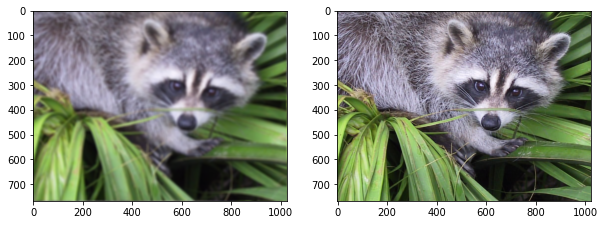

In [2]:

img = sample('face')
psf = point_spread_function(15, 5)
b = blurring(img, psf)

x = Variable()
data_term = sum_squares(conv(x, psf) - b)
reg_term = deep_prior(x, denoiser='ffdnet_color')
reg2 = nonneg(x)
prob = Problem(data_term + reg_term + reg2)

max_iter = 24
rhos, sigmas = log_descent(35, 30, max_iter)
out = prob.solve(method='admm', x0=b, pbar=True)

print(psnr(out, img))  # 31.50
imshow(b, out)


### Demosaicing

Image demosaicing is the process of reconstructing a full-color image from a partially sampled version captured by a color filter array (CFA). A CFA is a patterned color filter placed over the image sensor in a digital camera, where each pixel only captures a single color component (e.g., red, green, or blue). 



100%|██████████| 24/24 [00:00<00:00, 29.98it/s]


37.11165326163333


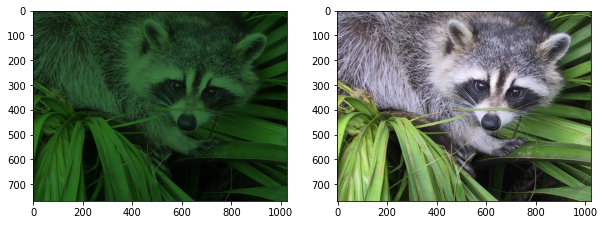

In [3]:
img = sample('face')
b = mosaicing(img)

x = Variable()
data_term = sum_squares(mosaic(x) - b)
reg_term = deep_prior(x, denoiser='ffdnet_color')
prob = Problem(data_term + reg_term)

max_iter = 24
rhos, sigmas = log_descent(35, 30, max_iter)
out = prob.solve(method='admm', x0=b, rhos=rhos, lams={reg_term: sigmas}, max_iter=max_iter, pbar=True)

print(psnr(out, img))  # 39.027
imshow(b, out)

### Joint Demosaic and Deconvolution

Joint demosaicing and deconvolution is a technique for simultaneously recovering a full-color image from a color filter array (CFA) and deblurring the image to reduce the effects of blur and noise. 

100%|██████████| 24/24 [04:58<00:00, 12.43s/it]


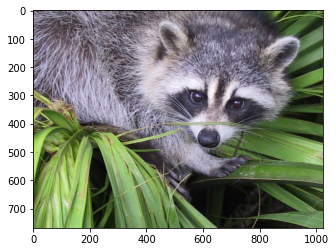

29.90187567633604


In [5]:
img = sample('face')
img = to_torch_tensor(img, batch=True).float()
psf = point_spread_function(15, 5)
b = blurring(img, psf)
b = mosaicing(b)

x = Variable()
data_term = sum_squares(mosaic(conv(x, psf)) - b)
reg_term = deep_prior(x, denoiser='ffdnet_color')
prob = Problem(data_term + reg_term,
                linear_solve_config=linalg.LinearSolveConfig(max_iters=500))

max_iter = 24
rhos, sigmas = log_descent(35, 30, max_iter)
out = prob.solve(method='admm', x0=b, rhos=rhos, lams={reg_term: sigmas}, max_iter=24, pbar=True)


imshow(out)
print(psnr(out, img)) # 29.689

### Super-Resolution

Image super-resolution is the process of recovering a high-resolution image from the low-resolution image. 

100%|██████████| 24/24 [00:00<00:00, 53.53it/s]


33.518213185746355


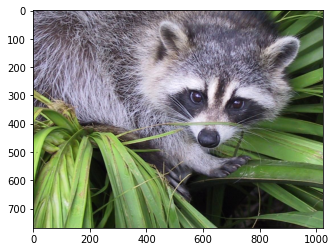

In [ ]:
img = sample('face')
psf = point_spread_function(5, 3)
y, x0 = downsampling(img, psf, sf=2)

x = Variable()
data_term = sisr(x, y, kernel=psf, sf=2)
reg_term = deep_prior(x, denoiser='ffdnet_color')
prob = Problem(data_term + reg_term)

max_iter = 24
rhos, sigmas = log_descent(35, 35, max_iter)

out = prob.solve(method='admm', x0=x0, rhos=rhos, lams={reg_term: sigmas}, max_iter=24, pbar=True)

print(psnr(out, img))  # 33.518
imshow(out)